In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

from astropy import table
from astropy.io import fits
from cxotime import CxoTime


- [Introduction](#Introduction)
- [The Dataset](#The-Dataset)
- [A Simple Fit](#A-Simple-Fit)
- [References and Resources](#References-and-Resources)

# Introduction

The ACA focal-plane detector is a 1024×1024 Tektronix CCD chip designed to operate between -6°C and -16°C (according to the [POG](https://cxc.harvard.edu/proposer/POG/html/chap5.html#tth_sEc5.2.1)). Over the mission, the ACA has operated at various temperatures. Until mid-2012 (?), the temperature was controlled. Since then, it has been allowed to drift, resulting in a steady increase in temperature.

<img src="https://cxc.cfa.harvard.edu/mta/ASPECT/acdc/2020/263/report_2020_263_23_47_51/t_ccd.png">


Dark current in the CCD camera is one of the main causes of ACA performance degradation and operational risk. It is expected that dark current should increase in the CCD camera, as pixels degrade after years of operation. Dark current is also very dependent on temperature.


The temperature dependence of the dark current is currently assumed to be of the form ([chandra_aca.dark_model.dark_temp_scale](https://github.com/sot/chandra_aca/blob/b03f0303e1421e4ca2dd212a9ec97891ef33f343/chandra_aca/dark_model.py#L53)):
$$
D_{e} = D_{e_0} \beta \frac{\Delta T}{4.0},
$$

where $\beta = \frac{1.0}{0.70}$.



# The Problem

The trend of warm pixel fraction (corrected to a reference temperature of -10 C) should be both smooth (basically linear over time scales of a year or less) and uncorrelated with CCD temperature. This is clearly not the case in the existing correction (taken from the [2020-09-19 DC calibration summary](https://cxc.cfa.harvard.edu/mta/ASPECT/acdc/2020/263/report_2020_263_23_47_51/index.html)):

<img src="https://cxc.cfa.harvard.edu/mta/ASPECT/acdc/2020/263/report_2020_263_23_47_51/frac100_raw.png">

The discrepancy is specially notable in the last few data points, when the temperature dropped by more than 5 C while one would not expect significan degradation in this short time. It discernible in 2003 and 2006 (?), when the operating temperature was changed to -10 and -15 C respectively.



# The Dataset

Dark cal processing proceeds as described in https://github.com/sot/acdc#processing-steps:

- **Process the raw VC2 data into the dark current Level-0 format**, which produces most files in `$SKA/data/acadc/<year>/<day>`.
- **Process the L0 files into individual 512x512 quadrant readouts**, which produces the `quad_*` files in `$SKA/data/acadc/<year>/<day>`.
- **Process quadrant readouts into final 1024x1024 dark current images**, whose out put is in `$SKA/data/acadc/cals/flight`.

In this analysis, we take the output from the second step and re-run the third step using the `--combine-alg two` option:

```
acdc_process_quads_to_cals --data-root $SKA/data/acadc --combine-alg two --start 2001:001
```

This option causes the processing script to combine two consecutive SRDCs that have 5- and 10-second integration times into one image.
The benefit there is that you take out cosmic ray hits which are basically noise on your signal. The actual temperature change during the few minutes of a SRDC dark cal is small since the usual timescale for cycling is many hours. The change during a cal won't have any measurable impact on the final result.
There is just one CCD temperature in the products associated with all 8 quad readouts from a single SRDC.

After quadrant readouts are process into images two-by-two, we gather all these images in a single file (`all_cals.fits`) for convenience:

In [9]:
def read_cals(cal_root=None):
    if cal_root is None:
        cal_root = Path(os.environ['SKA']) /'data' / 'acdc' / 'cals' / 'two'
    else:
        cal_root = Path(cal_root)

    assert cal_root.exists(), 'ACDC data dir does not exist: {cal_root}'

    def read_cal_file(filename):
        with fits.open(filename) as hdus:
            hdu = hdus[0]
            img = hdu.data
            header = dict(hdu.header)
        return img, header
    cal_root = Path(cal_root)
    cal_table = table.Table.read(str(cal_root / 'cal_index.dat'), format='ascii.ecsv')
    imgs = []
    headers = []
    for ii in tqdm(range(len(cal_table))):
        cal = cal_table[ii]
        year, doy, hh, mm, ss = cal['date'].split(':')
        cal_dir = cal_root / year / doy
        cal_file = cal_dir / cal['filename']
        img, header = read_cal_file(cal_file)
        imgs.append(img)
        headers.append(header)
    cals = table.Table(headers)
    cals['IMG'] = imgs

    # I will use temperature in Kelvin
    cals['T_CCD'] += 273.15

    # this is for convenience, for when I want to split the sample
    cals['group'] = np.arange(len(cals))%10

    # assign an ID that increases with T_CCD
    cals['TIME'] = CxoTime(cals['DATE'])
    cals.sort(keys=['T_CCD'])
    cals['ID'] = np.arange(len(cals))
    cals.sort(keys=['TIME'])
    cals.remove_column('TIME')

    cals.write('all_cals.fits')

if not os.path.exists('all_cals.fits'):
    read_cals()

100%|██████████| 523/523 [00:21<00:00, 24.31it/s]


In [49]:
def calculate_means():
    from tqdm import tqdm
    import cxotime

    t_start = cxotime.CxoTime('2020:195')
    t_stop = cxotime.CxoTime('2020-11-01')
    t_ref = cxotime.CxoTime('2020:254:02:36:26.000')

    cals = table.Table.read('all_cals.fits')
    cals['t'] = cxotime.CxoTime(cals['DATE'])
    cals['TIME'] = cals['t'].cxcsec
    cals['i'] = np.arange(len(cals))

    cals = cals[cals['t'] > t_start]
    #cals = cals[(cals['t'] > t_start) & (cals['t'] < t_stop)]
    
    pairs = np.array([(i, j) for i in range(len(cals)) for j in range(len(cals))])

    means = []
    for i1, i2 in tqdm(pairs):
        df = table.Table()
        df['DC'] = cals['IMG'][i1].flatten()
        df['T_CCD'] = cals['T_CCD'][i1].astype(np.float32)
        df['DC_2'] = cals['IMG'][i2].flatten()
        df['T_CCD_2'] = cals['T_CCD'][i2].astype(np.float32)
        df['i'] = cals['i'][i1]
        df['j'] = cals['i'][i2]
        df['group'] = cals['group'][i1]
        df['TIME'] = cals['TIME'][i1].astype(np.float32)

        df['f_DC'] = np.inf
        df['f_DC'][df['DC'] != 0] = df['DC_2'][df['DC'] != 0]/df['DC'][df['DC'] != 0]
        df['DC_bin'] = np.digitize(df['DC'], bins=np.logspace(1, 4, 31))

        df = df[(~np.isnan(df['DC'])) & (~np.isnan(df['DC_2']))]
        df = df[(df['DC'] > 0) & (df['DC_2'] > 0)]

        g = df.group_by(['i', 'DC_bin'])
        m = g[['i', 'DC_bin', 'TIME', 'j', 'DC', 'DC_2', 'T_CCD', 'T_CCD_2', 'f_DC']].groups.aggregate(np.mean)
        m['n'] = g[['j']].groups.aggregate(np.sum)['j']/m['j']
        for col in ['DC', 'DC_2', 'f_DC']:
            m[f'{col}_std'] = np.std([m[col]])
            m[f'{col}_median'] = np.median([m[col]])

        means.append(m)

    means = table.vstack(means)
    means.sort(['T_CCD'])
    means.write('means.csv')

if not os.path.exists('means.csv'):
    calculate_means()

100%|██████████| 1600/1600 [28:23<00:00,  1.06s/it]


# A Simple Fit

In [50]:
means = table.Table.read('means.csv')
means.sort(keys=['T_CCD', 'i'])

In [51]:
def line(x, a, b):
    return a + b*x

indices = np.unique(means['i'])
indices = np.array(sorted(indices, key=lambda i: means['T_CCD'][means['i'] == i][0]))

In [52]:
def do_fits():
    stack = []
    for ref_index in indices:
        dc_bins = np.unique(means['DC_bin'])
        scale_params = np.zeros((len(dc_bins), 2))
        scale_cov = np.zeros((len(dc_bins), 2, 2))
        dc = np.ones((len(dc_bins)))*np.nan
        t_ccd = np.ones((len(dc_bins)))*np.nan
        for i, b in enumerate(dc_bins):
            s = (means['DC_bin'] == b) & (means['i'] == ref_index)
            if np.sum(s) < 3:
                continue
            x = means['T_CCD_2'][s]
            y = means['DC_2'][s]
            scale_params[i], scale_cov[i] = opt.curve_fit(line, (x - 273.15), np.log(y))
            dc[i] = np.mean(means['DC'][s & (means['j'] == ref_index)])
            t_ccd[i] = np.mean(means['T_CCD'][s & (means['j'] == ref_index)])
        scale_params = scale_params[~np.isnan(dc)]
        scale_cov = scale_cov[~np.isnan(dc)]
        t_ccd = t_ccd[~np.isnan(dc)]
        dc = dc[~np.isnan(dc)]
        t = table.Table()
        t['params'] = scale_params
        t['covariance'] = scale_cov
        t['DC'] = dc
        t['T_CCD'] = t_ccd
        t['log_DC'] = np.log(dc)
        t['i'] = ref_index
        stack.append(t)
    return table.vstack(stack)

In [53]:
def plot(ref_index, stride=4):
    dc_bins = list(range(5,31))
    bin_indices = list(range(len(dc_bins)))
    for i in bin_indices[::stride]:
        b = dc_bins[i]

        s = (means['DC_bin'] == b) & (means['i'] == ref_index)
        if np.sum(s) < 3:
            continue
        x = means['T_CCD_2'][s]
        y = means['DC_2'][s]

        DC = means['DC'][s & (means['j'] == ref_index)][0]
        #print(DC)
        l = plt.scatter(x - 273.15, y,
                         marker='o')
        #l = plt.errorbar(x, y,
        #                 ls='none',
        #                 marker='.').lines[0]
        scale_params = fits['params'][(fits['i'] == ref_index) & (fits['DC'] == DC)][0]
        plt.plot(x - 273.15, np.exp(line(x - 273.15, *scale_params)), color=l.get_facecolor()[0])
        plt.axvline(means['T_CCD'][s][0] - 273.15, color='k')

    plt.yscale('log')
    #plt.legend()

In [54]:
fits = do_fits()

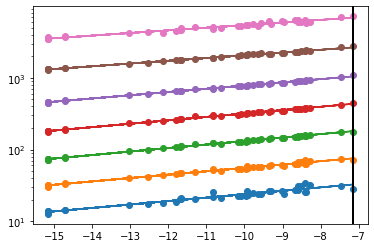

In [55]:
plot(indices[-1])

In [56]:
min_DC = 50
DC = fits['DC'][fits['DC'] > min_DC]
T_CCD = fits['T_CCD'][fits['DC'] > min_DC]
ALPHA = fits['params'].T[1][fits['DC'] > min_DC]

def f(x, a, b, c, d, e):
    y = x.T[1] - e*x.T[0]
    return a + b*x.T[0] + c*y + d*y**2

p0 = [-4.88802057e+00, -1.66791619e-04, -2.22596103e-01, -2.45720364e-03, 1.90718453e-01]

params, cov = opt.curve_fit(f, np.vstack([T_CCD, np.log(DC)]).T, ALPHA, p0=p0)
params

array([-2.33532534e+00,  2.82688267e-05, -1.52072600e-01, -2.36991665e-03,
        1.39510313e-01])

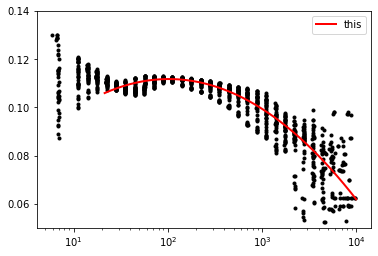

In [59]:
for i in indices:
    t = fits[fits['i'] == i]
    l = plt.plot(t['DC'], t['params'].T[1], '.', color='k')

x = np.vstack([np.ones(41)*263.15, np.log(np.logspace(1.33, 4, 41))]).T
plt.plot(np.exp(x.T[1]), f(x, *params), color='r', label='this', linewidth=2)

plt.xscale('log')
plt.ylim(bottom=0.05, top=0.14)
plt.legend()

In [60]:
params, np.sqrt(np.diag(cov))

(array([-2.33532534e+00,  2.82688267e-05, -1.52072600e-01, -2.36991665e-03,
         1.39510313e-01]),
 array([4.64669670e-01, 1.58919031e-04, 1.52914707e-02, 1.02012984e-04,
        1.31014436e-02]))

In [18]:
def f(x, a, b, c, d, e):
    a, b, c, d, e = [-4.88802057e+00, -1.66791619e-04, -2.22596103e-01, -2.45720364e-03, 1.90718453e-01]
    y = x.T[1] - e*x.T[0]
    return a + b*x.T[0] + c*y + d*y**2

# Digging a bit more

(0.05, 0.1347013439355795)

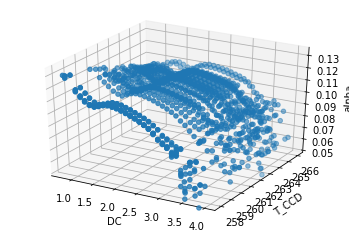

In [61]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log10(fits['DC']), fits['T_CCD'], fits['params'].T[1], marker='o')

ax.set_xlabel('DC')
ax.set_ylabel('T_CCD')
ax.set_zlabel('alpha')

ax.set_zlim(bottom=0.05)

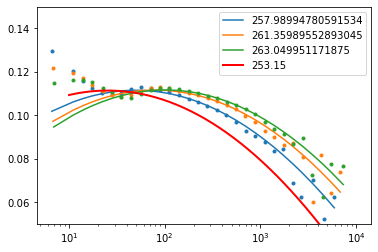

In [62]:
for i in [0, 10, 19]:
    i = indices[i]
    t = fits[fits['i'] == i]
    l = plt.plot(t['DC'], t['params'].T[1], '.')
    x = np.vstack([t['T_CCD'], t['log_DC']]).T
    plt.plot(t['DC'], f(x, *params),
             color=l[0].get_color(),
             label=means[means['i'] == i]['T_CCD'][0])

x = np.vstack([np.ones(41)*253.15, np.log(np.logspace(1., 4, 41))]).T
plt.plot(np.exp(x.T[1]), f(x, *params), color='r', label='253.15', linewidth=2)

plt.xscale('log')
plt.ylim(bottom=0.05, top=0.15)
plt.legend()

In [63]:
x = np.logspace(1, 3, 11)
x = np.vstack([np.ones_like(x)*253.4, np.log(np.logspace(1, 3, 11))]).T
f(x, *params)

array([0.10917461, 0.1107792 , 0.11137859, 0.11097277, 0.10956174,
       0.10714551, 0.10372408, 0.09929744, 0.09386559, 0.08742855,
       0.07998629])

(0.05, 0.1344366872527848)

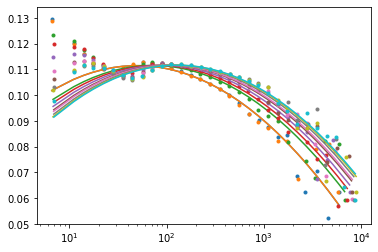

In [64]:
for i in indices[::4]:
    t = fits[fits['i'] == i]
    l = plt.plot(t['DC'], t['params'].T[1], '.')
    x = np.vstack([t['T_CCD'], t['log_DC']]).T
    plt.plot(t['DC'], f(x, *params), color=l[0].get_color())

plt.xscale('log')
plt.ylim(bottom=0.05)

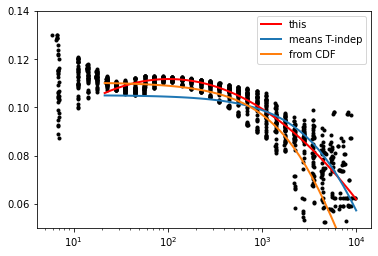

In [65]:
for i in indices:
    t = fits[fits['i'] == i]
    l = plt.plot(t['DC'], t['params'].T[1], '.', color='k')

x = np.vstack([np.ones(41)*263.15, np.log(np.logspace(1.33, 4, 41))]).T
plt.plot(np.exp(x.T[1]), f(x, *params), color='r', label='this', linewidth=2)
#plt.plot(np.exp(x.T[1]), 0.108*np.exp( -np.exp(x.T[1])/11000), label='means T-indep', linewidth=2)
plt.plot(np.exp(x.T[1]), 0.105*np.exp( -np.exp(x.T[1])/16500), label='means T-indep', linewidth=2)
plt.plot(np.exp(x.T[1]), 0.1103*np.exp(-np.exp(x.T[1])/7744.), label='from CDF', linewidth=2)

plt.xscale('log')
plt.ylim(bottom=0.05, top=0.14)
plt.legend()

In [66]:
params, np.sqrt(np.diag(cov))

(array([-2.33532534e+00,  2.82688267e-05, -1.52072600e-01, -2.36991665e-03,
         1.39510313e-01]),
 array([4.64669670e-01, 1.58919031e-04, 1.52914707e-02, 1.02012984e-04,
        1.31014436e-02]))

In [67]:
params, np.sqrt(np.diag(cov))

(array([-2.33532534e+00,  2.82688267e-05, -1.52072600e-01, -2.36991665e-03,
         1.39510313e-01]),
 array([4.64669670e-01, 1.58919031e-04, 1.52914707e-02, 1.02012984e-04,
        1.31014436e-02]))

In [68]:
def f(x):
    a, b, c, d, e = [-4.88802057e+00, -1.66791619e-04, -2.22596103e-01, -2.45720364e-03, 1.90718453e-01]
    y = x.T[1] - e*x.T[0]
    return a + b*x.T[0] + c*y + d*y**2

# Summary

The dark current ($DC$) scaling from CCD temperature $T_0$ to CCD temperature $T_1$ is roughly exponential:

$
DC_1 = e^{\alpha (T_1 - T_0)} DC_0
$

This is another way of expressing Arrhenius equation applied to the CCD current, with an exponent $\alpha$ that depends on the temperature and the dark current. The fit above gives the exponent as a function of $T_{CCD}$ and $DC$:

$
\alpha = p_0 + p_1 T_{CCD} + p_2 (\log{DC} - p_4 T_{CCD}) + p_3 (\log{DC} - p_4 T_{CCD})^2
$

with 

```
p = [
    -4.88802057e+00,
    -1.66791619e-04,
    -2.22596103e-01,
    -2.45720364e-03,
    1.90718453e-01
]
```

Things not explicitly explored in this notebook:
- It might prove useful to estimate the exponent at a fixed reference temperature in the middle of the typical temperature range. I used $T_{CCD}=263.15$ above.
- the exponent fit does not work well for $DC < 20$ or so, so I suggest clipping all values below 20.


In [ ]:
def exponent(dc, t_ccd=265.15):
    a, b, c, d, e = [
        -4.88802057e+00,
        -1.66791619e-04,
        -2.22596103e-01,
        -2.45720364e-03,
        1.90718453e-01
    ]
    y = np.log(np.clip(dc, 20, 1e4)) - e*t_ccd
    return a + b*t_ccd + c*(np.log(dc) - e*t_ccd) + d*y**2

# References and Resources

- Current [dark current calibration pages](https://cxc.cfa.harvard.edu/mta/ASPECT/acdc/)
- Legacy [dark current calibration pages](https://asc.harvard.edu/mta/ASPECT/#Dark_Current)
- [ACDC](https://github.com/sot/acdc): Ska3 package for ACA Dark Current Calibration processing.
- [TK1024 Spec Sheet](#TK1024)
- [dark current parametric model](https://nbviewer.jupyter.org/url/asc.harvard.edu/mta/ASPECT/analysis/dark_current_model/dark_model.ipynb) built to extrapolate the dark current years into the future for estimating performance up to 5 years out
- <a id="Widenhorn_2002"> </a>Ralf Widenhorn, Morley M. Blouke, Alexander Weber, Armin Rest, and Erik Bodegom "Temperature dependence of dark current in a CCD", Proc. SPIE 4669, Sensors and Camera Systems for Scientific, Industrial, and Digital Photography Applications III, (24 April 2002); https://doi.org/10.1117/12.463446. (<a href="http://web.pdx.edu/~d4eb/ccd/SPIE_2002.pdf">link from author's web page </a>)

# Appendix

## TK1024 Spec Sheet
<a id="TK1024">

<img src="sheet.png" style="width:500px">

The simplest model for the DC-Temperature dependence is given by Arrhenius law:

$$
D_{e} = D_{e_0} E^{-\Delta E/kT},
$$